# DATA SETUP

In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import os
import matplotlib.pyplot as plt
import gdal
from rasterstats import zonal_stats
from sklearn.decomposition import PCA
import shapefile
import pickle
from osgeo import gdal
from osgeo import osr
import csv

In [3]:
import wget
import time
import json

## 1. Define Data Region by creating a shapefile:
We'll clip our images by this after we have merged and reprojected them.

In [7]:
#Import CSV containing corners of full dataset region rectangle:
with open('coordinates_iraq.csv', 'rb') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_NONNUMERIC) #keeps numbers as floats
    vertices = list(reader)

print list(vertices)

w = shapefile.Writer(shapefile.POLYGON)
w.poly(parts=[vertices])
w.field('X')
w.field('Y')
w.record('Full_Iraq','Polygon')
w.save('Full_Iraq')

[[291080.258, 4046600.322], [497928.764, 4046600.322], [497928.764, 3920424.396], [291080.258, 3920424.396]]


## 2. SRTM Region is already covered by the complete SRTM created for NE Syria
The existing SRTM image we downloaded for Northeastern Syria, includes our Northern Iraq data region.  We just need to reproject it into UTM Zone 38N (as we are shifting over into a new UTM Zone by shifting East into Iraq), make sure it's 30m resolution, and then clip it:

In [32]:
!gdalwarp -t_srs epsg:32638 -tr 30 30 srtm_complete.tif srtm_complete_UTM38N.tif

Creating output file that is 32233P x 38576L.
Processing input file srtm_complete.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [33]:
srtm_stats = zonal_stats('Full_Iraq.shp', 'srtm_complete_UTM38N.tif', raster_out=True)
srtm = srtm_stats[0]['mini_raster_array']
srtm_affine = srtm_stats[0]['mini_raster_affine']

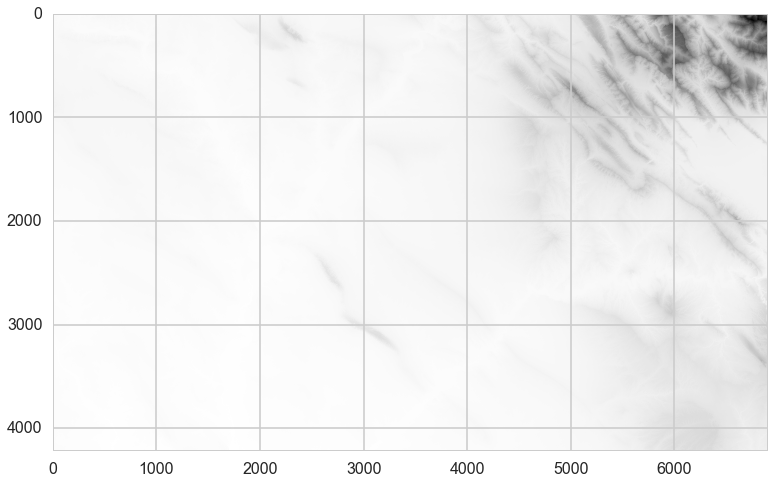

In [34]:
plt.imshow(srtm.data)

## 3. Loading and Clipping Landsat 8 Images

The Landsat8 images have been chosen to cover the areas we are studying by looking at 
geo-localisation systems and selecting the images that correspond to the latitute and longitude 
of the required area.

In [3]:
!echo $SHELL

$SHELL


In [15]:
list_images = !landsat search --cloud 4  -p 171,035
image = []
clouds = []
htmls = []
LCs = []
for i in xrange(len(np.str(list_images).split("{',"))-2):
    image.append(np.str(list_images).split("{',")[i+2])
    clouds.append(np.float((image[i].split("cloud")[1]).split(",")[0].split(": ")[1]))
    htmls.append("http"+image[i].split("http")[1].split(",")[0][:-2])
    LCs.append(image[i].split("sceneID")[1].split(",")[0][4:-1])

smallest_cloud = np.str(LCs[np.argmin(clouds)])
second_smallest = np.str(LCs[np.argsort(clouds)[1]])
print smallest_cloud, second_smallest

LC81710352015234LGN00 LC81710352015138LGN00


In [12]:
LCs[np.argsort(clouds)[1]]

'LC81710352015138LGN00'

In [16]:
!landsat download LC81710352015234LGN00

===> Downloading: LC81710352015234LGN00_B4.TIF
     LC81710352015234LGN00_B4.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_B3.TIF
     LC81710352015234LGN00_B3.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_B2.TIF
     LC81710352015234LGN00_B2.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 2.49 seconds


In [13]:
!landsat download LC81710352015234LGN00 --bands 678

===> Downloading: LC81710352015234LGN00_B6.TIF
   100%     64.0 MiB     442.8 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B7.TIF

     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B8.TIF
   100%    247.1 MiB     550.0 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 717.58 seconds


In [14]:
!landsat download LC81710352015234LGN00 --bands 91011

===> Downloading: LC81710352015234LGN00_B9.TIF
   100%     37.5 MiB     490.7 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B10.TIF
   100%     46.4 MiB     595.4 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_B11.TIF
   100%     43.9 MiB     515.2 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 246.26 seconds


In [18]:
!landsat download LC81710352015234LGN00 --bands 1

===> Downloading: LC81710352015234LGN00_B1.TIF
   100%     58.1 MiB     584.9 KiB/s            0:00:00 ETA    
     stored at /Users/macuser/landsat/downloads/LC81710352015234LGN00
===> Downloading: LC81710352015234LGN00_BQA.TIF
     LC81710352015234LGN00_BQA.TIF already exists on your system
===> Downloading: LC81710352015234LGN00_MTL.txt
     LC81710352015234LGN00_MTL.txt already exists on your system
===> Download Completed
===> Done!
Time spent : 102.75 seconds


In [23]:
image = []
clouds = []
htmls = []
LCs = []
for i in xrange(len(np.str(list_images).split("{',"))-2):
    image.append(np.str(list_images).split("{',")[i+2])
    clouds.append(np.float((image[i].split("cloud")[1]).split(",")[0].split(": ")[1]))
    htmls.append("http"+image[i].split("http")[1].split(",")[0][:-2])
    LCs.append(image[i].split("sceneID")[1].split(",")[0][4:-1])

smallest_cloud = np.str(LCs[np.argmin(clouds)])
second_smallest = np.str(LCs[np.argsort(clouds)[1]])
print smallest_cloud, second_smallest

LC81710342013228LGN00


In [36]:
!landsat download LC81710342013228LGN00 --bands 123

===> Downloading: LC81710342013228LGN00.tar.bz
     LC81710342013228LGN00.tar.bz already exists on your system
===> Download Completed
===> Done!
Time spent : 0.41 seconds


In [ ]:
!landsat download LC81710342013228LGN00 --bands 456

In [ ]:
!landsat download LC81710342013228LGN00 --bands 789

In [35]:
!landsat download LC81710342013228LGN00 --bands 1011

===> Downloading: LC81710342013228LGN00.tar.bz
     LC81710342013228LGN00.tar.bz already exists on your system
===> Download Completed
===> Done!
Time spent : 0.77 seconds


In [5]:
## NEED TO UNZIP THE LANDSAT IMAGES: TAR.BZ
import tarfile
tarfile.open(name='/Users/macuser/landsat/downloads/LC81710342013228LGN00.tar.bz')

## Merge the Landsat Images Together:
(They're already in the correct UTM Zone, as before)

In [15]:
%%bash
#assuming all files are in the same directory, use virtual dataset to lazily evalute as in here (http://www.perrygeo.com/lazy-raster-processing-with-gdal-vrts.html):
for i in {1..11};
  do
    gdalbuildvrt -srcnodata 0 lc_merged_B$i.vrt LC*B$i.TIF;
  done

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
%%bash
#Write each merged set of files to a TIF
for i in {1..11};
  do
    gdalwarp -srcnodata 0 -dstalpha lc_merged_B$i.vrt lc_merged_B$i.TIF
  done

Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B1.vrt.
Copying nodata values from source lc_merged_B1.vrt to destination lc_merged_B1.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B2.vrt.
Copying nodata values from source lc_merged_B2.vrt to destination lc_merged_B2.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B3.vrt.
Copying nodata values from source lc_merged_B3.vrt to destination lc_merged_B3.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B4.vrt.
Copying nodata values from source lc_merged_B4.vrt to destination lc_merged_B4.TIF.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B5.

### Then, extrapolate Band 8 to the same resolution (30m):

In [17]:
!gdalwarp -tr 30 30 lc_merged_B8.TIF lc_merged_B8_30m_res.tif

Creating output file that is 12411P x 7991L.
Processing input file lc_merged_B8.TIF.
Using band 2 of source image as alpha.
Using internal nodata values (e.g. 0) for image lc_merged_B8.TIF.
Copying nodata values from source lc_merged_B8.TIF to destination lc_merged_B8_30m_res.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [17]:
!rm lc_merged_B8.TIF

### And, finally, clip the images to our data region, using the shapefile created at the beginning of the notebook

In [18]:
path = "./"
bands = os.listdir(path)
tif_files = [f for f in bands if f.endswith('.TIF') and f.startswith("lc_merged")]

In [19]:
clip_images =[]
for i in tif_files:
    lc_stats = zonal_stats('Full_Iraq.shp', i, raster_out=True)
    lc = lc_stats[0]['mini_raster_array']
    clip_images.append(lc.data)

## 3. Loading Corona Images

Here, we download Corona images that overlap with our region of interest.  Looking at the footprints on the [Corona Atlas of the Middle East](http://corona.cast.uark.edu/index.html#bbox=4417244,4122523,5346107,4534672), mission 1104-2138 (Fore) best captures this region, so we downloaded images 1 through 12 from this mission below.  Because, we've moved east into Northern Iraq, we are now in UTM Zone 38N, so we have adjusted the code accordingly.

In [12]:
#download Corona aerial photographs from University of Arkansas' collection from 1-12
for i in xrange(1,12):
    url = 'http://cast-ftp1.cast.uark.edu/coronaftp/1102-1025d/1102-1025df/ds1102-1025df0%02d.ntf' % (i)
    wget.download(url)

In [10]:
%%bash

for i in {01..11};
  do
    gdalwarp -t_srs epsg:32638 ds1104-2138df0$i.ntf out$i.tif;
  done

Creating output file that is 107466P x 27779L.
Processing input file ds1104-2138df001.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107481P x 27851L.
Processing input file ds1104-2138df002.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107472P x 27810L.
Processing input file ds1104-2138df003.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107480P x 27811L.
Processing input file ds1104-2138df004.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107209P x 27617L.
Processing input file ds1104-2138df005.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107367P x 27812L.
Processing input file ds1104-2138df006.ntf.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 107431P x 27632L.
Processing input file ds1104-2138df007.nt

Merge Corona images together:

In [13]:
!gdalbuildvrt -srcnodata 0 corona_merged_iraq.vrt out01.tif out02.tif out03.tif out04.tif out05.tif out06.tif out07.tif out08.tif out09.tif out10.tif out11.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


Extrapolate Corona imagery to 30 meter accuracy as we did with the NE Syria data:

In [14]:
!gdalwarp -srcnodata 0 -dstalpha -tr 30 30 corona_merged_iraq.vrt corona_merged_iraq.tif

Creating output file that is 8138P x 6320L.
Processing input file corona_merged_iraq.vrt.
Copying nodata values from source corona_merged_iraq.vrt to destination corona_merged_iraq.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [44]:
corona_stats = zonal_stats('Full_Iraq.shp', 'corona_merged_iraq.tif', raster_out=True)
corona = corona_stats[0]['mini_raster_array']
corona_affine = corona_stats[0]['mini_raster_affine']

In [49]:
#Compare max y/min x coordinates (will impact how many pixels included in the clip)
#Notice 
print "Max Y Coordinate (m):"
print "Corona: ", corona_affine[5]

#produce a landsat example for measuring max Y and Min X
lc_stats = zonal_stats('Full_Iraq.shp', tif_files[0], raster_out=True)
lc = lc_stats[0]['mini_raster_array']
lc_affine = lc_stats[0]['mini_raster_affine']

print "Landsat: ", lc_affine[5]
print "SRTM: ", srtm_affine[5]

print "\nMin X Coordinate (m):"
print "Corona: ", corona_affine[2]
print "Landsat: ", lc_affine[2]
print "SRTM: ", srtm_affine[2]

Max Y Coordinate (m):
Corona:  4046601.77019
Landsat:  4046625.0
SRTM:  4046608.96684

Min X Coordinate (m):
Corona:  291058.334566
Landsat:  291075.0
SRTM:  291055.714268


### Line up the images to make sure their 30m resolution pixels align.  The Max Y Coordinates above in conjunction with an additional row of pixels indicate that Landsat and SRTM have pixels slightly too high, so we trim these to match each other better

In [59]:
print np.shape(corona.data.flatten())
print np.shape(srtm.data[1:].flatten()) #SRTM data has one more row of pixels higher than others (just above 30m threshold)
print np.shape(clip_images[0][1:].flatten()) #Landsat has one more row of pixels higher than others (just above 30m threshold)

(29004576L,)
(29004576L,)
(29004576L,)


In [58]:
#We get the size of the clipped landsat images
rows = clip_images[1].shape[0]
cols = clip_images[1].shape[1]

#Create a matrix with the clipped landsat images, each at the appropriate size
bands_matrix = np.zeros(((rows-1)*cols,len(clip_images)))
for idx, i in enumerate(clip_images):
    data = i[1:].flatten()
    bands_matrix[:,idx] = data

In [60]:
np.save('coronaIraq.npy', corona.data.flatten())
np.save('srtmIraq.npy', srtm.data[1:].flatten())
np.save('landsatIraq.npy', bands_matrix)